In [1]:
# general data set, path and visualizer related imports
import os
import sys
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy.stats as scs
import seaborn as sb
import dvc.api
import mlflow
import mlflow.sklearn
warnings.filterwarnings("ignore")

# modeling, cross validation and scoring related imports
from datetime import datetime
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_validate

In [2]:
# set up paths and helper scripts
sys.path.append('.')
sys.path.insert(1, '../scripts/')

import defaults as defs
import dataCleaner as dc
import dataVisualizer as dv
import mlHelper as mlh

# setup helper scripts
cleaner = dc.dataCleaner('ml modeling notebook')
visualizer = dv.dataVisualizer('ml modeling notebook')
mlHelper = mlh.machineLearningHelper('ml modeling notebook')

--> <Logger dataCleaner (WARNING)>
logger <Logger dataCleaner (INFO)> created at path: ../logs/cleaner_root.log
Data cleaner in action
--> <Logger dataVisualizer (WARNING)>
logger <Logger dataVisualizer (INFO)> created at path: ../logs/visualizer_root.log
Data visualizer in action
--> <Logger mlHelper (WARNING)>
logger <Logger mlHelper (INFO)> created at path: ../logs/ml_preprocess_root.log
Data preprocessor in action


* Platform os split: version 4 of the dataset

* Browser split: version 5 of the dataset

In [3]:
# TODO : refactor this 
# read data using dvc
version = 'v5'

# data path using dvc api
data_url = dvc.api.get_url(path = defs.path, 
                           repo = defs.repo, 
                           rev = version)

# reading the csv file
missing_values = ["n/a", "na", "undefined", '?', 'NA', 'undefined']
df = pd.read_csv(data_url, na_values=missing_values)
df

,Unnamed: 0,experiment,hour,date,device_make,browser,awareness
0,0,1,2,2,4,2,0
1,1,1,16,1,13,1,1
2,2,1,8,3,13,1,0
3,3,0,4,5,43,4,1
4,4,0,15,0,13,1,0
...,...,...,...,...,...,...,...
1238,1238,1,21,2,13,1,1
1239,1239,1,1,1,13,1,1
1240,1240,0,7,6,13,1,0
1241,1241,0,16,7,13,1,0


## Ml modeling

* Clean unwanted rows

In [4]:
df = cleaner.remove_unwanted_cols(df, ['Unnamed: 0'])
df

,experiment,hour,date,device_make,browser,awareness
0,1,2,2,4,2,0
1,1,16,1,13,1,1
2,1,8,3,13,1,0
3,0,4,5,43,4,1
4,0,15,0,13,1,0
...,...,...,...,...,...,...
1238,1,21,2,13,1,1
1239,1,1,1,13,1,1
1240,0,7,6,13,1,0
1241,0,16,7,13,1,0


* Setting up ml flow experiment

In [5]:
# setting up ml flow experiment
mlflow.set_experiment('ml modeling')
mlflow.start_run()

mlflow.log_param('data_url', data_url)
mlflow.log_param('data_version', version)
mlflow.log_param('input_rows', df.shape[0])
mlflow.log_param('input_cols', df.shape[1])

### Training models

* Platform os split: version 4 of the dataset

* Browser split: version 5 of the dataset

In [6]:
# set up the data, differentiating the training features and the target
X = df.iloc[: , :-1]
y = df.iloc[: , -1]

In [7]:
mlflow.log_param('features', X.columns.to_list())
mlflow.log_param('target', 'awareness')

### Cross validation: 5 folds 

* Using shuffle split and defining scoring metrics

In [8]:
# shuffle split using 5 folds and tet size of 2%
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 77)

# scoring metrics
#long_scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'accuracy', 'precision', 'recall', 'f1',  'neg_log_loss']
scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'accuracy', 'precision']
mlflow.log_param('scoring', scoring)
mlflow.log_param('cross_validation', cv)

#### Classifier one: logistic regression

In [9]:
# logistic regression parameters
log_reg_params = {'random_state' : 77}

# logistic regression classifier pipeline
log_reg_pipeline = Pipeline([("scaler", preprocessing.StandardScaler()),
                            ('log_reg_classifier', LogisticRegression(random_state = 77))])

# logistic regression classifier cross validation
log_reg_results = cross_validate(log_reg_pipeline, X, y, cv = cv, scoring = scoring, 
                                return_train_score = False, return_estimator = True)
# save the model
joblib.dump(log_reg_pipeline._final_estimator, '../models/log_reg_model.pkl')

# logging parameters, models and metrics
mlflow.log_param('log reg parameters', log_reg_params)
mlflow.log_artifact("../models/log_reg_model.pkl")
# mlflow.log_metric('log reg metrics', log_reg_results)

CV: 1
Importance: [ 0.00806167  0.09503814  0.01007358 -0.01300681 -0.032171  ]


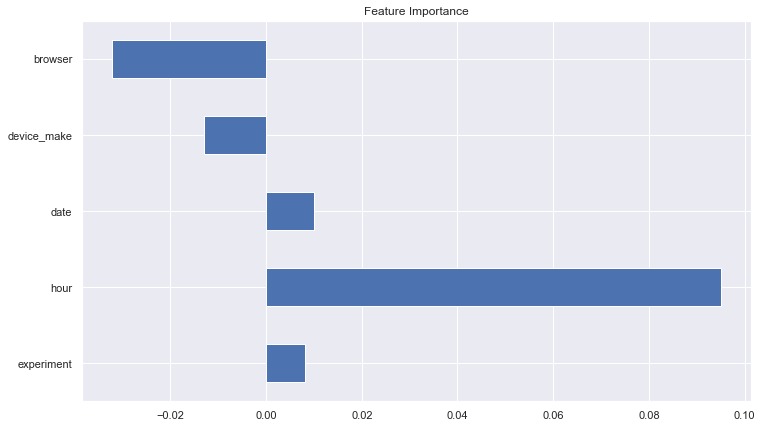

CV: 2
Importance: [ 0.06399135  0.11698666 -0.00440268  0.10736672 -0.08050977]


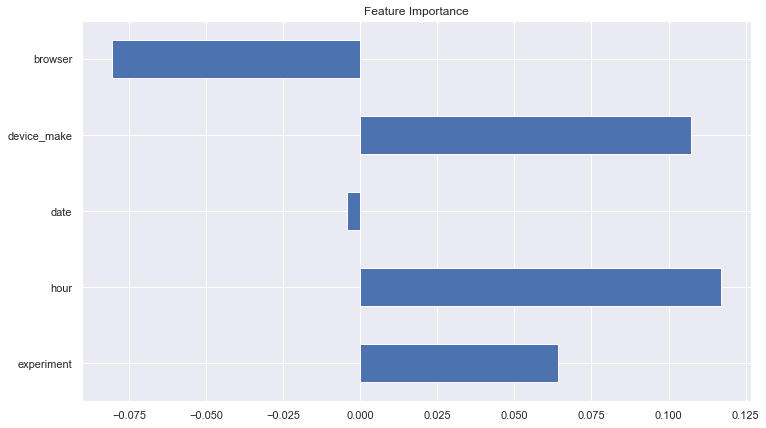

CV: 3
Importance: [ 0.05827405  0.12824363 -0.02075375  0.09654713 -0.03531756]


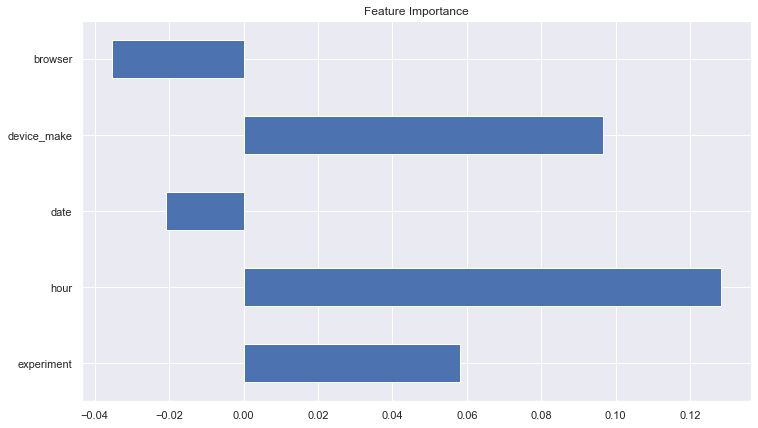

CV: 4
Importance: [ 0.0520174   0.11548259 -0.02198752  0.02878286 -0.00615935]


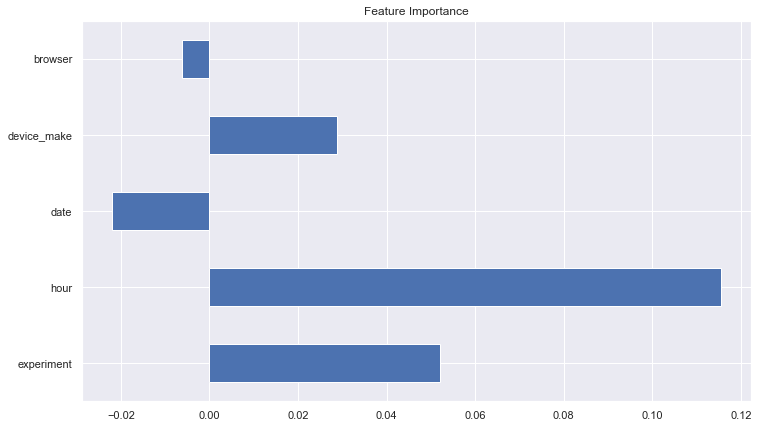

CV: 5
Importance: [ 0.07813754  0.130771   -0.02530983  0.11714569 -0.08294001]


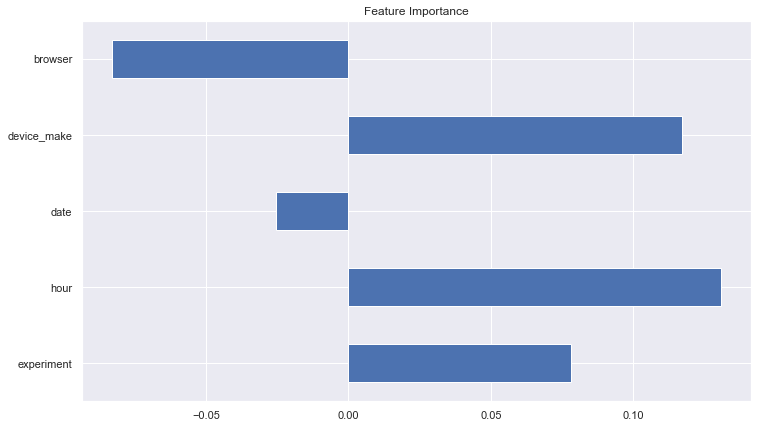

In [10]:
for i in range(0, 5, 1):
    importance = log_reg_results['estimator'][i]['log_reg_classifier'].coef_[0]
    print(f'CV: {(i+1)}\nImportance: {importance}')
    #importance is a list so you can plot it.
    plt.figure(figsize=(12, 7))
    feat_importance = pd.Series(importance, index=X.columns)
    #feat_importance.nlargest(20).plot(kind='barh',title = 'Feature Importance')
    feat_importance.plot(kind='barh',title = 'Feature Importance')
    plt.show()

#### Classifier two: decision tree

In [11]:
# decision tree parameters
decision_tree_params = {'random_state' : '77'}

# decision tree classifier pipeline
decision_tree_pipeline = Pipeline([('scaler', preprocessing.StandardScaler()),
                                ('decision_tree_classifier', DecisionTreeClassifier(random_state = 77))])

# decision tree classifier cross validation
decision_tree_results = cross_validate(decision_tree_pipeline, X, y, cv = cv, scoring = scoring, 
                                return_train_score = False, return_estimator = True)
# save the model
joblib.dump(decision_tree_pipeline._final_estimator, '../models/decision_tree_model.pkl')

# logging parameters, models and metrics
mlflow.log_param('decision tree parameters', decision_tree_params)
mlflow.log_artifact("../models/decision_tree_model.pkl")
# mlflow.log_metric('decision tree metrics', decision_tree_results)

CV: 1
Importance: [0.03513476 0.3720084  0.24027483 0.26333372 0.0892483 ]


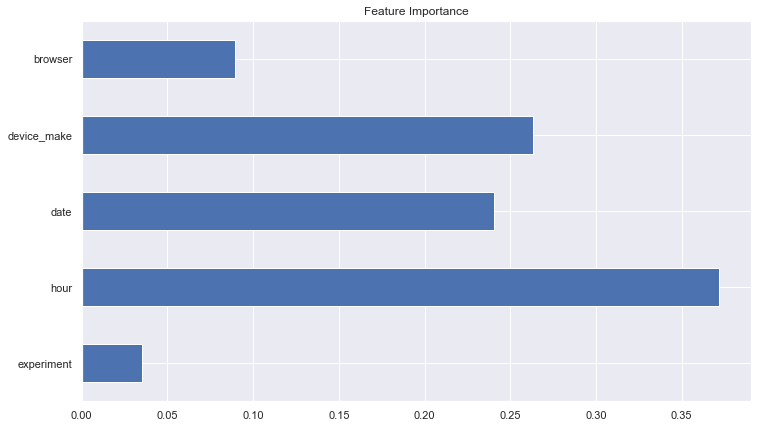

CV: 2
Importance: [0.09603528 0.29150312 0.28767594 0.21669687 0.1080888 ]


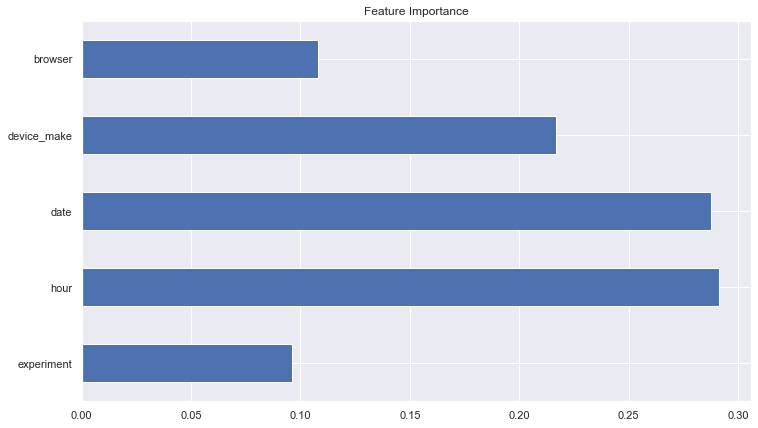

CV: 3
Importance: [0.09909289 0.27939832 0.21423375 0.30602548 0.10124955]


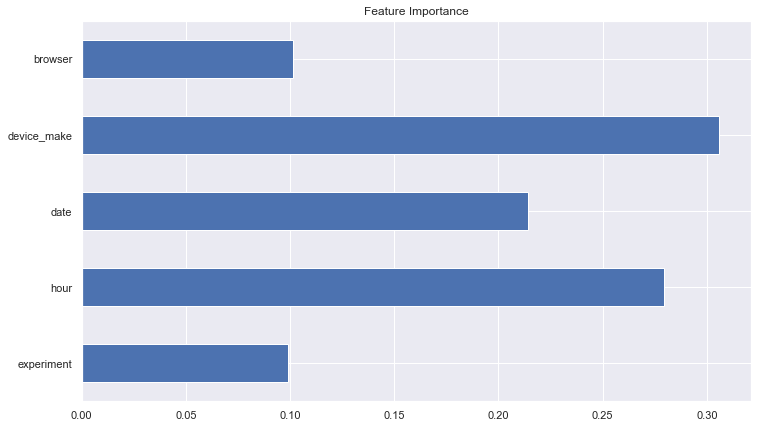

CV: 4
Importance: [0.07779652 0.25847339 0.27015639 0.28596393 0.10760977]


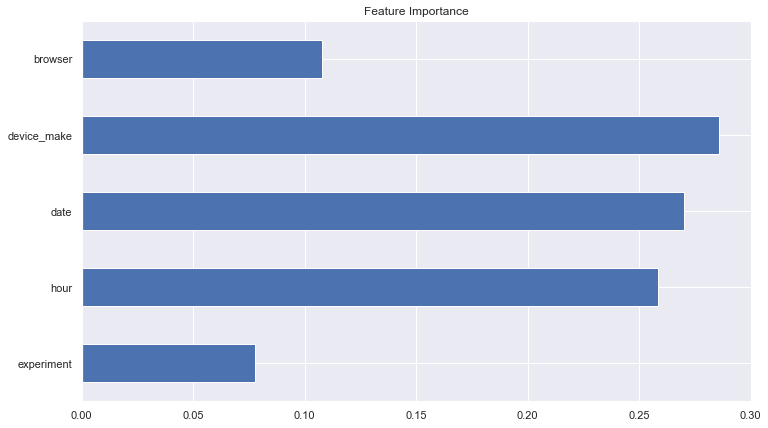

CV: 5
Importance: [0.07112727 0.39829709 0.15357269 0.27348581 0.10351714]


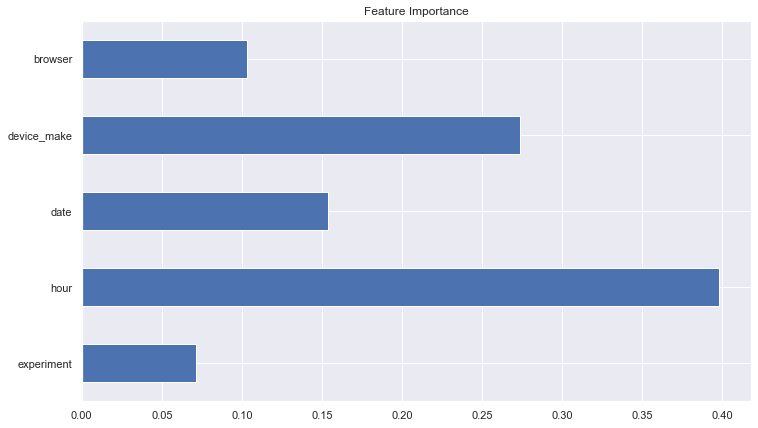

In [12]:
for i in range(0, 5, 1):
    importance = decision_tree_results['estimator'][i]['decision_tree_classifier'].feature_importances_
    print(f'CV: {(i+1)}\nImportance: {importance}')
    #importance is a list so you can plot it.
    plt.figure(figsize=(12, 7))
    feat_importance = pd.Series(importance, index=X.columns)
    # feat_importance.nlargest(20).plot(kind='barh',title = 'Feature Importance')
    feat_importance.plot(kind='barh',title = 'Feature Importance')
    plt.show()


#### Classifier three: XGB

In [13]:
# xgb parameters
xgb_params = {"objective":"binary:logistic", 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

# convert the dataset into an optimized data structure named Dmatrix that XGB supports
data_dmatrix = xgb.DMatrix(data = X, label = y)

# XGBoost classifier cross validation
xgb_results = xgb.cv(dtrain = data_dmatrix, params = xgb_params, nfold = 5,
                        num_boost_round = 50, early_stopping_rounds = 10, 
                        metrics = "rmse", as_pandas=True, seed=77)

xg_class = xgb.train(dtrain = data_dmatrix, params = xgb_params, num_boost_round = 50)

# save the model
joblib.dump(xg_class, '../models/xgb_classification_model.pkl')

# logging parameters, models and metrics
mlflow.log_param('xgb parameters', xgb_params)
mlflow.log_artifact("../models/xgb_classification_model.pkl")
# mlflow.log_metric('xgb metrics', xgb_results)

* End and stop ml flow experiment

In [14]:
mlflow.end_run()

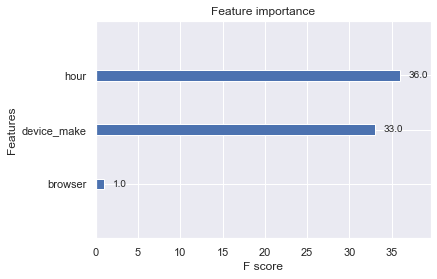

In [15]:
# feature importance
xgb.plot_importance(xg_class)
plt.rcParams['figure.figsize'] = [12, 7]
plt.show()
# mlflow.log_artifact('feature importance', plt)

#### Based on the feature importance plots plotted above we can clearly see that different types of models have different feature importance variables.


1. Logistic regression model: Hour, device make and experiment are the top features respectively.

2. Decision tree model: Hour, date and device make are the top features respectively.

3. XBG model: Hour and device make are the top features respectively

### Metrics report

* Mean report

In [16]:
# Mean report for all three classifier
mlHelper.print_result(log_reg_results, scoring, 'mean')
mlHelper.print_result(decision_tree_results, scoring, 'mean')
xgb_results.head()


--- Mean Report ---
fit time: 0.1095
score time: 0.0138
test_r2: -0.8326
test_neg_mean_squared_error: -0.4538
test_neg_root_mean_squared_error: -0.6732
test_neg_mean_absolute_error: -0.4538
test_accuracy: 0.5462
test_precision: 0.5398

--- Mean Report ---
fit time: 0.0901
score time: 0.009
test_r2: -0.9412
test_neg_mean_squared_error: -0.4803
test_neg_root_mean_squared_error: -0.6928
test_neg_mean_absolute_error: -0.4803
test_accuracy: 0.5197
test_precision: 0.4704


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.499761,0.000103,0.499822,0.000135
1,0.499561,0.000188,0.499681,0.000263
2,0.499394,0.000258,0.499567,0.000384
3,0.499164,0.000335,0.499512,0.000491
4,0.498969,0.000377,0.499431,0.000623


* Standard deviation

In [17]:
# Standard deviation report for all three classifiers
mlHelper.print_result(log_reg_results, scoring, 'std')
mlHelper.print_result(decision_tree_results, scoring, 'std')


--- Standard deviation Report ---
fit time: 0.1672
score time: 0.0032
test_r2: 0.1168
test_neg_mean_squared_error: 0.0331
test_neg_root_mean_squared_error: 0.0248
test_neg_mean_absolute_error: 0.0331
test_accuracy: 0.0331
test_precision: 0.1122

--- Standard deviation Report ---
fit time: 0.1548
score time: 0.0025
test_r2: 0.1155
test_neg_mean_squared_error: 0.0279
test_neg_root_mean_squared_error: 0.0202
test_neg_mean_absolute_error: 0.0279
test_accuracy: 0.0279
test_precision: 0.0472
